In [1]:
# Installed scikit-video (skvideo) and ffmpeg from conda
# https://anaconda.org/conda-forge/sk-video
# https://anaconda.org/conda-forge/ffmpeg

import skvideo.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

# skvideo can either use vread or vreader
# vreader uses a generator (loads frames on-demand to save memory)

# If file is avi:
file_name = 'case1.avi'
frames = skvideo.io.vread(file_name, as_grey = True)

# # If file is tiff:
# import skimage.io
# file_name = 'musical_robot.tiff'
# frames = skimage.io.imread(file_name)

In [2]:
frames.shape

(1250, 480, 640, 1)

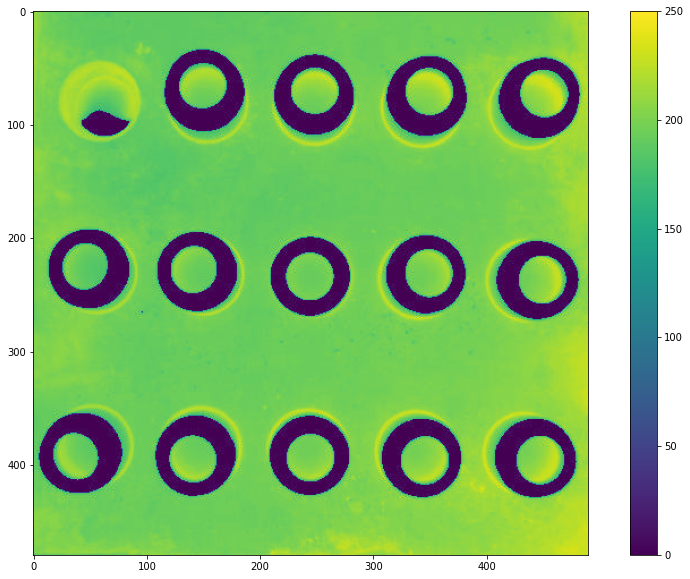

In [4]:
# If file is avi:
# vread generates a (50 * 480 * 640 * 1) array for the test case in greyscale
# Use pyplot's imshow to plot arrays as images
# imshow takes 2D arrays, the frames are x*y*z so use array.squeeze to reduce to x*y 

image = frames[200].squeeze()
crop = (95, 585)
image = image[:, crop[0]:crop[1]] # Crop image if necessary

# # If file is tiff: no need to squeeze image
# image = frames[1]
# image = image[:, :]

plt.figure(figsize = (15,10))
# plt.imshow(image)
plt.imshow(image)
plt.colorbar()

Use image segmentation on frame and see if edges can be found

Next question - how to segment each of the circles?

https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html this looks like what we want to do

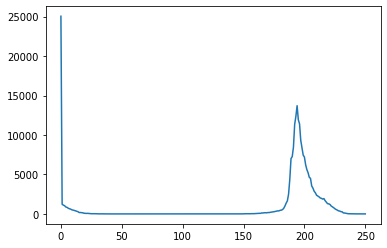

In [5]:
# from skimage import data
from skimage.exposure import histogram

hist, hist_centers = histogram(image)

plt.plot(hist)

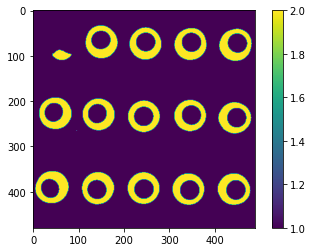

In [6]:
markers = np.zeros_like(image)
markers[image < 150] = 2 # Here I've inverted the markers because the vial edge is cold
markers[image > 45] = 1
plt.imshow(markers)
plt.colorbar()

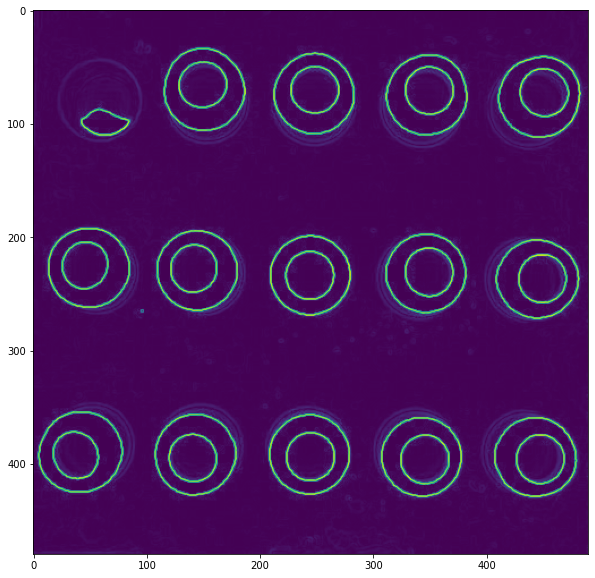

In [7]:
from skimage.filters import sobel
elevation_map = sobel(image)

plt.figure(figsize = (15,10))
plt.imshow(elevation_map)

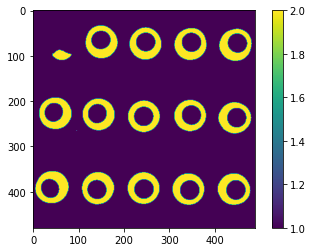

In [8]:
from skimage.segmentation import watershed
segmentation = watershed(elevation_map, markers)

plt.imshow(segmentation)
plt.colorbar()

Labelling with ndi.label() works by assigning each pixel a label value, try e.g. labeled[50]

the labeled object can then be processed with e.g. morphology.remove_small_objects, which works on pixel area

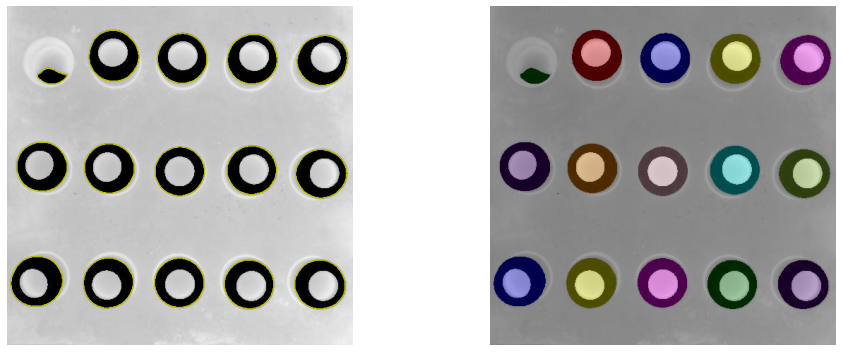

In [9]:
from skimage.color import label2rgb

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled, image=image, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

In [10]:
from skimage.measure import label, regionprops
from skimage import morphology

# Remove small artifacts - size of the vials is ~4000
labeled_clean = morphology.remove_small_objects(labeled, 1000)
regions = regionprops(labeled_clean)


for i in regions:
#     print(i.area)
    print(i.centroid)

(69.81501004016064, 150.52986947791166)
(73.49133247089263, 247.75912031047866)
(74.50051124744377, 347.33844580777094)
(76.15258511979823, 446.79672131147544)
(226.9440470107307, 48.76520183955033)
(229.3512535538899, 144.40656500387698)
(231.83386243386244, 346.4367724867725)
(233.52695240599527, 244.25111753878517)
(236.8489339573583, 444.9435777431097)
(389.6948736816286, 41.43414275202355)
(391.79262086513995, 142.85699745547075)
(391.63335073068896, 243.61717118997913)
(393.818588730911, 342.6282253817799)
(394.086878061356, 443.1964423820572)


Write these centroids by scatter plot

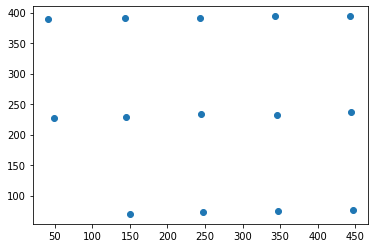

In [11]:
# Append centroids to list
# Note - zip(*[list]) makes zip work in reverse - tuple to lists rather than list to tuples

centroids = [i.centroid for i in regions]
x, y = zip(*[(i[1], i[0]) for i in centroids])

plt.scatter(x, y)

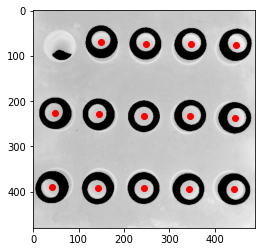

In [12]:
fig, axes = plt.subplots()
axes.imshow(image, cmap=plt.cm.gray)
axes.scatter(x,y, color='r')

Alternative approach: erode labelled regions
https://forum.image.sc/t/shrink-labeled-regions/50443/10

In [13]:
# https://forum.image.sc/t/shrink-labeled-regions/50443/10

def erode_labels(segmentation, erosion_iterations):
    from scipy import ndimage
    # create empty list where the eroded masks can be saved to
    list_of_eroded_masks = list()
    regions = regionprops(segmentation)
    def erode_mask(segmentation_labels, label_id, erosion_iterations):
        
        only_current_label_id = np.where(segmentation_labels == label_id, 1, 0)
        eroded = ndimage.binary_erosion(only_current_label_id, iterations = erosion_iterations)
        relabeled_eroded = np.where(eroded == 1, label_id, 0)
        return(relabeled_eroded)

    for i in range(len(regions)):
        label_id = regions[i].label
        list_of_eroded_masks.append(erode_mask(segmentation, label_id, erosion_iterations))

    # convert list of numpy arrays to stacked numpy array
    final_array = np.stack(list_of_eroded_masks)

    # max_IP to reduce the stack of arrays, each containing one labelled region, to a single 2D np array. 
    final_array_labelled = np.sum(final_array, axis = 0)
    return(final_array_labelled)

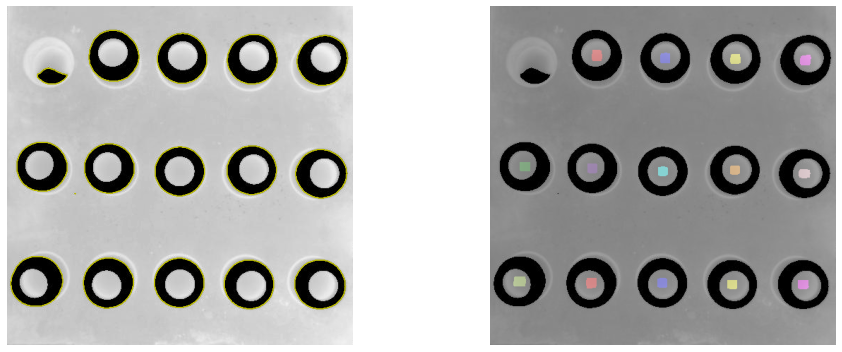

In [14]:
# segmentation = ndi.binary_fill_holes(segmentation - 1)
# labeled, _ = ndi.label(segmentation)

labeled_eroded = erode_labels(labeled, 28)
image_label_overlay = label2rgb(labeled_eroded, image=image, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)

for a in axes:
    a.axis('off')

# Add label numbers
# for i in regions:
#     plt.text(int(i.centroid[1]), int(i.centroid[0]), i.label, c = 'w', fontweight = 'bold')
    
plt.tight_layout()
plt.show()

In [15]:
# Remember to include the 'intensity_image' parameter
regions = regionprops(labeled_eroded, intensity_image = image)

for i in regions:
#     print(i.mean_intensity)
    print(i.area)

221
197
196
209
194
191
174
181
193
236
210
188
178
192


In [16]:
frames.squeeze().shape

(1250, 480, 640)

In [17]:
# Read out all of the regions' time series
# Remember to crop intensity image if necessary

temps = []

for i in frames.squeeze():
    regions = regionprops(labeled_eroded, intensity_image = i[:, crop[0]:crop[1]])
    temps.append([i.mean_intensity for i in regions])

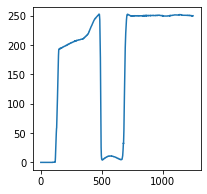

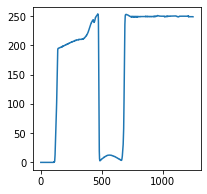

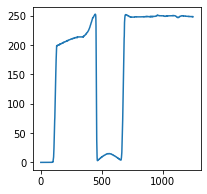

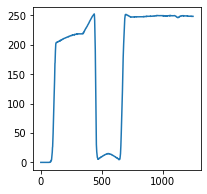

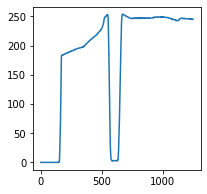

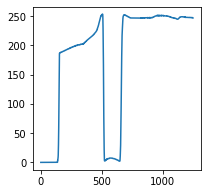

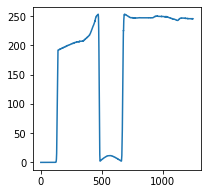

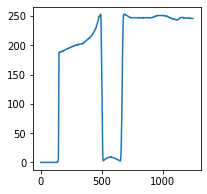

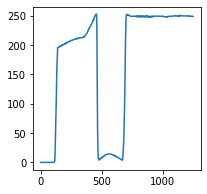

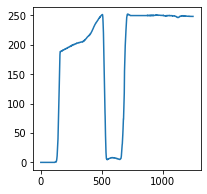

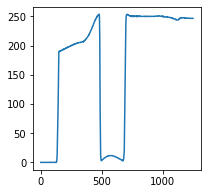

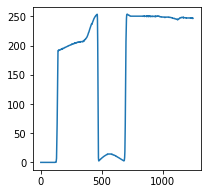

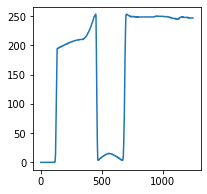

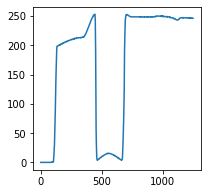

In [18]:
for j in range(len(regions)):
    x = [i[j] for i in temps]
    plt.figure(figsize=(3,3))
    plt.plot(x)
    plt.show()